## Forecasting AAVAIL revenue using ARIMA

In [1]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from my_modules.data_utils import fetch_data, fetch_ts, engineer_features
from my_modules.plot_utils import plotarima

%matplotlib inline

In [2]:
DATA_DIR = './data/cs-train'
ts_data = fetch_ts(DATA_DIR)

UK_df = ts_data['united_kingdom']

... loading ts data from files


In [3]:
UK_df.dtypes

date                object
purchases            int64
unique_invoices      int64
unique_streams       int64
total_views          int64
year_month          object
revenue            float64
dtype: object

In [4]:
UK_df.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


Extracting revenue as feature

In [5]:
feature_mean = UK_df[['date', 'revenue']].copy()
feature_mean.index = pd.to_datetime(feature_mean['date'])
feature_mean = feature_mean.asfreq(freq="D", method='bfill')
feature_mean.head()

,date,revenue
date,,
2017-11-01,2017-11-01,0.0
2017-11-02,2017-11-02,0.0
2017-11-03,2017-11-03,0.0
2017-11-04,2017-11-04,0.0
2017-11-05,2017-11-05,0.0


## Manual forecasting using Autoregressive Integrated Moving Average (ARIMA)

ARIMA depend on the values p, d, q

p = number of lags, AR terms

d = order of differencing

q = number of lagged forecast errors, MA terms

In [7]:
timeseries = feature_mean['revenue']

Augmented Dickey Fuller (ADF) test to see if the timeseries is stationary:

In [8]:
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 1.8230636695066428e-08


The p-value is smaller than the significance level 0.05 so it seems timeseries is  stationary and differencing is not needed, d == 0

#### Lets just quckly validate this for different values for d using autocorrelation:

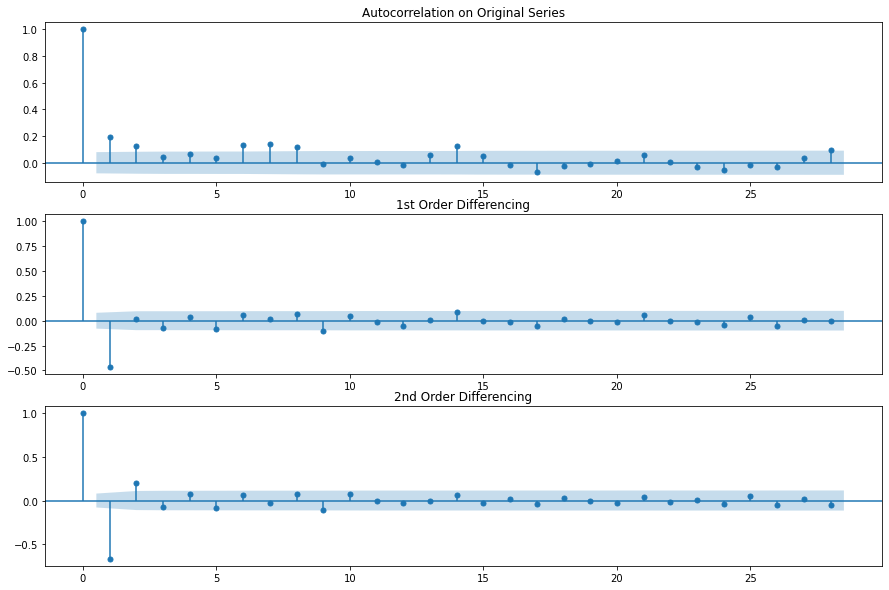

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

The timeseries is stationary at **d = 1** (all but one should be under the significance level), but d = 0 seems fine also.

If your series is slightly under differenced, try adding an additional AR and if it is slightly over-differenced, maybe add an additional MA term.

Probably adding additional AR will work with d = 0. We can probably also try using d = 1.

#### Value for p is the amount of lags bigger than the significance level in partial autocorrelation

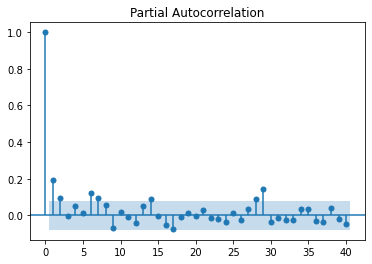

In [10]:
plot_pacf(timeseries.dropna(), lags=40) #knowing d=0 we don't apply diff()
plt.show()

In [ ]:
Lag 1 is above the signicance level and so **p = 1**.

#### Number of q using autocorrelation on the stationary series:

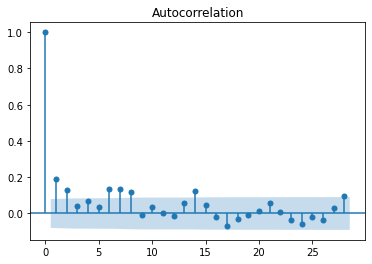

In [11]:
plot_acf(timeseries.dropna())
plt.show()

One above the significance level and thus **q = 1**.

#### Building the model

In [16]:
model = ARIMA(timeseries, order=(1, 0, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                revenue   No. Observations:                  607
Model:                     ARMA(1, 1)   Log Likelihood               -6407.514
Method:                       css-mle   S.D. of innovations           9292.961
Date:                Thu, 11 Feb 2021   AIC                          12823.028
Time:                        14:12:39   BIC                          12840.662
Sample:                    11-01-2017   HQIC                         12829.889
                         - 06-30-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5701.7033    671.288      8.494      0.000    4386.002    7017.405
ar.L1.revenue     0.8470      0.090      9.402      0.000       0.670       1.024
ma.L1.revenue    -0.7267      0.119     -6.116      0.000      -0.960      -0.494
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1806           +0.0000j            1.1806            0.0000
MA.1            1.3762           +0.0000j            1.3762            0.0000
-----------------------------------------------------------------------------
"""

Akaike information criterion (AIC) estimates the relative amount of information lost by a given model. The less the better!

Now for the prediction:

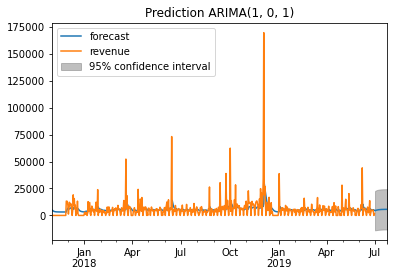

In [18]:
graph = results.plot_predict(1, 630)
plt.title(label="Prediction ARIMA(1, 0, 1)")
plt.show()

## Timeseries forecasting using auto_arima

In [8]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

TRAIN_SIZE = 450

# Load/split your data
train, test = train_test_split(timeseries, train_size=TRAIN_SIZE)

# Fit your model
model = pm.auto_arima(train, start_p=1, start_q=1, test="adf", seasonal=True, m=30, trace=True)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=9625.528, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=9610.636, Time=0.99 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=9614.883, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=9751.421, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=9609.095, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=9610.573, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=9612.573, Time=0.96 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=9606.308, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=9607.848, Time=1.00 sec
 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=9607.807, Time=0.69 sec
 ARIMA(2,0,0)(1,0,1)[30] intercept   : AIC=9609.806, Time=1.40 sec
 ARIMA(3,0,0)(0,0,0)[30] intercept   : AIC=9608.303, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=9608.306, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[30]

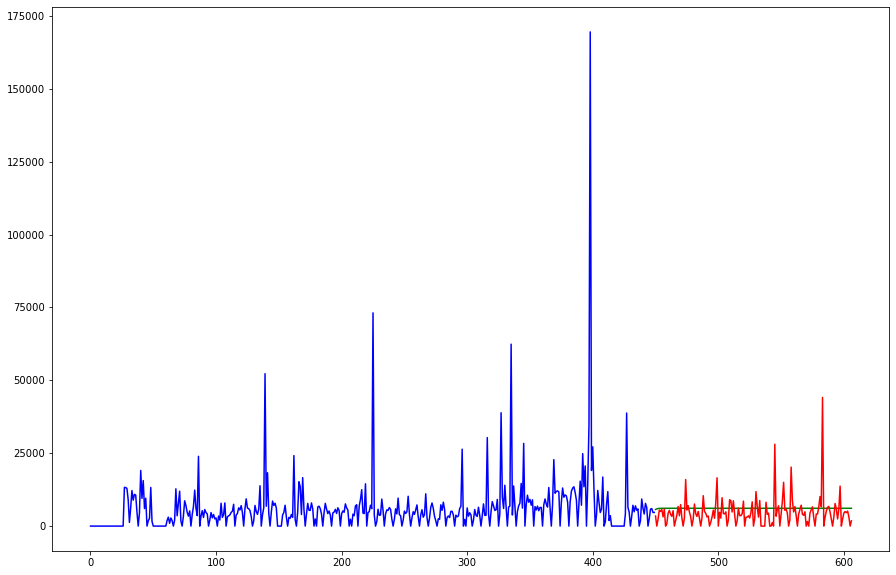

In [20]:
# Visualize the forecasts (blue=train, green=forecasts, red=real data)
x = np.arange(timeseries.shape[0])
plt.plot(x[:TRAIN_SIZE], train, c='blue')
plt.plot(x[TRAIN_SIZE:], forecasts, c='green')
plt.plot(x[TRAIN_SIZE:], test, c='red')
plt.show()

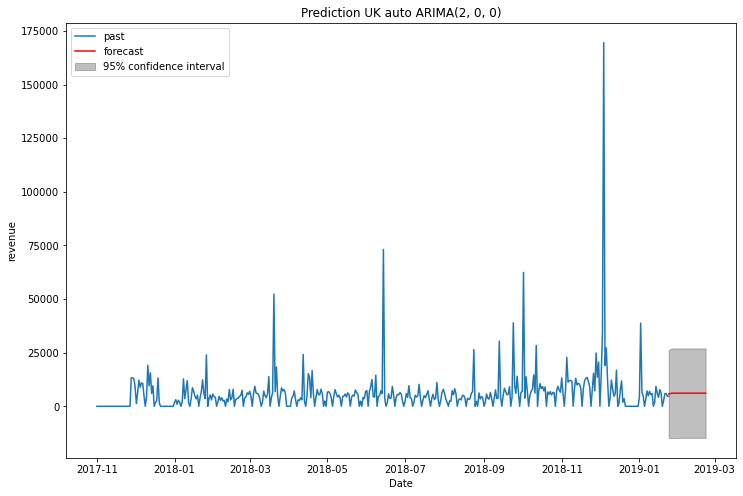

In [9]:
plotarima(30, train, model, title="Prediction UK auto ARIMA(2, 0, 0)")

## Discussion

In [ ]:
Manually we got (p, d , q) = (1, 0, 1) and auto_arima found the lowest AIC value with (2, 0, 0).
